# 使用 k 近邻算法改进网站的配对效果

In [44]:
#导入矩阵运算模块
import numpy as np
import operator

**文件到矩阵转换（准备数据）**

数据集文件datingTestSet2.txt保存在当前目录下，也即是把txt拷贝到本地的用户文件夹下（我的）
输入：文件  输出：数据集的特征矩阵returnMat和标签向量classLabelVector 

In [45]:
def file2matrix(filename):
    love_dictionary = {'largeDoses':3, 'smallDoses':2, 'didntLike':1}    # 三个类别
    fr = open(filename)    # 打开文件
    arrayOLines = fr.readlines()    # 逐行打开
    numberOfLines = len(arrayOLines)            #得到文件的行数
    returnMat = np.zeros((numberOfLines, 3))        #初始化特征矩阵
    classLabelVector = []                       #初始化输出标签向量
    index = 0
    for line in arrayOLines:#循环处理文件中的每行数据
        line = line.strip()    # 删去字符串首部尾部空字符
        listFromLine = line.split('\t')    # 按'\t'对字符串进行分割，得到列表
        returnMat[index, :] = listFromLine[0:3]    # listFromLine的0,1,2元素是特征，赋值给returnMat的当前行
        if(listFromLine[-1].isdigit()):    # 如果listFromLine最后一个元素是数字
            classLabelVector.append(int(listFromLine[-1]))    # append 的作用是在列表的末尾添加元素，直接赋值给classLabelVector
        else:    # 如果listFromLine最后一个元素不是数字，而是字符串
            classLabelVector.append(love_dictionary.get(listFromLine[-1]))    # 根据字典love_dictionary转化为数字
        index += 1
    return returnMat, classLabelVector    # 返回的类别标签classLabelVector是1,2,3

**数据归一化**

输入：数据矩阵 输出：归一化的数据矩阵normDataSet 范围 ranges 有3列 最小值minVals 3列

In [46]:
def autoNorm(dataSet):
    minVals = dataSet.min(0)#从列中选择最小值
    maxVals = dataSet.max(0)#从列中选择最大值
    ranges = maxVals - minVals
    normDataSet = np.zeros(np.shape(dataSet))#shape返回矩阵中维度 此句相当于创建一个同等规模的0矩阵
    m = dataSet.shape[0]#取矩阵的行数
    normDataSet = dataSet - np.tile(minVals, (m, 1))#函数title用于扩充minVals成m行1列
    normDataSet = normDataSet/np.tile(ranges, (m, 1))   # normDataSet值被限定在[0,1]之间
    return normDataSet, ranges, minVals

**对数据分析**

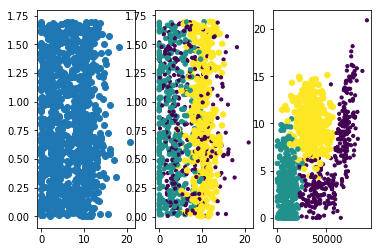

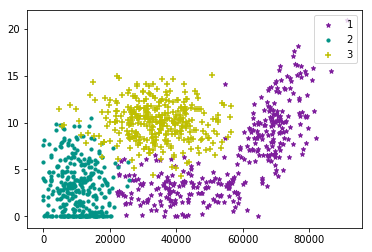

In [99]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import operator
import logging
datingDataMat, datingLabels = file2matrix('datingTestSet2.txt')
fig=plt.figure()
ax=fig.add_subplot(131)#1*3的第一个
ax.scatter(datingDataMat[:,1],datingDataMat[:,2])#第二列和第三列数据
#plt.show()
ax=fig.add_subplot(132)
ax.scatter(datingDataMat[:,1],datingDataMat[:,2],10.0*np.array(datingLabels),10.0*np.array(datingLabels))
ax=fig.add_subplot(133)
#datingLabels的值为1、2、3 每个数据点的大小不一样
ax.scatter(datingDataMat[:,0],datingDataMat[:,1],10.0*np.array(datingLabels),10.0*np.array(datingLabels))

fig=plt.figure()
ax=fig.add_subplot(111)
#datingLabels=array(datingLabels)
idx_1=np.where(np.array(datingLabels)==1)
p1=ax.scatter(datingDataMat[idx_1,0],datingDataMat[idx_1,1],marker = '*',color ='xkcd:purple',label='1',s=20)
idx_2=np.where(np.array(datingLabels)==2)
p2=ax.scatter(datingDataMat[idx_2,0],datingDataMat[idx_2,1],marker = 'o',color ='xkcd:teal',label='2',s=10)
idx_3=np.where(np.array(datingLabels)==3)
p3=ax.scatter(datingDataMat[idx_3,0],datingDataMat[idx_3,1],marker = '+',color ='y',label='3',s=30)
plt.legend(loc = 'upper right')
plt.show()#最后显示即可
#scatter函数参考 https://www.cnblogs.com/shanlizi/p/6850318.html
#matplot 官方教程 https://matplotlib.org/tutorials/colors/colors.html#sphx-glr-tutorials-colors-colors-py
#最后一张图参考 http://blog.sina.com.cn/s/blog_8d249b140102wf3m.html 并修改其中的错误

**KNN分类器**

输入：测试集inX，训练集dataSet，训练样本标签lebels，取的最近邻个数k 输出：返回K近邻中所属类别最多的一类
参考：https://www.cnblogs.com/vrfighters/articles/4715527.html 写的不错

In [47]:
def classify0(inX, dataSet, labels, k):
    dataSetSize = dataSet.shape[0]#得到行数
    diffMat = np.tile(inX, (dataSetSize, 1)) - dataSet#title 相当于将inX扩充为dataSeetSize行目的是为了和后面的训练集求距离
    sqDiffMat = diffMat**2
    sqDistances = sqDiffMat.sum(axis=1)#求和axis=1表示对所在行的全部列求和
    distances = sqDistances**0.5
    sortedDistIndicies = distances.argsort()#从小到大排序并找到索引值可参考：https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html和https://www.cnblogs.com/yyxf1413/p/6253995.html
    classCount = {}#创建字典，用于存储各标签出现的次数
    for i in range(k):#从上述的k个排序好的点，统计类别次数
        voteIlabel = labels[sortedDistIndicies[i]]#解释 距离最小的数据样本的标签参考
                                                   #：https://blog.csdn.net/zengxyuyu/article/details/54382182
        classCount[voteIlabel] = classCount.get(voteIlabel, 0) + 1#获取键值voteIlabel对应的值（次数），若不存在则为0
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)#将字典分解为元组列表，并按照第二个元素（次数）排序 true 为降序排列 默认升序 
    #参考：http://www.runoob.com/python/python-func-sorted.html
    return sortedClassCount[0][0]#得到k近邻中所属类别最多的类

**测试算法（完整程序需要调用前面的子函数）**

输入：样本，输出：分类结果和实际类别 ，错误率，错误个数

In [55]:
def datingClassTest():
    hoRatio = 0.10      #整个数据集的10%用来测试
    datingDataMat, datingLabels = file2matrix('datingTestSet2.txt')       #导入数据集
    normMat, ranges, minVals = autoNorm(datingDataMat)    # 所有特征归一化
    m = normMat.shape[0]    # 样本个数（行）
    numTestVecs = int(m*hoRatio)    # 测试样本个数
    errorCount = 0.0
    #对测试数据遍历
    for i in range(numTestVecs):
        #对每一条数据进行分类
        classifierResult = classify0(normMat[i, :], normMat[numTestVecs:m, :], datingLabels[numTestVecs:m], 3)
       #输出分类结果和实际的类别
        print("the classifier came back with: %d, the real answer is: %d" % (classifierResult, datingLabels[i]))
      #如果分类结果和实际不符
    if (classifierResult != datingLabels[i]): errorCount += 1.0
    print("the total error rate is: %f" % (errorCount / float(numTestVecs)))    # 打印错误率
    print(errorCount)    # 打印错误个数

In [53]:
datingClassTest() 

the classifier came back with: 3, the real answer is: 3
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answe

**使用算法（构建完整可用系统）**

依据用户输入3个参数，输出：判断结果类别
详细注释;参考：https://blog.csdn.net/quincuntial/article/details/50471423

In [52]:
def classifyPerson():
    resultList = ['not at all', 'in small doses', 'in large doses']#定义分类结果类别
   #读取输入的数据  percentTats  ffMiles  iceCream
    percentTats = float(input(\
                                  "percentage of time spent playing video games?"))
    ffMiles = float(input("frequent flier miles earned per year?"))
    iceCream = float(input("liters of ice cream consumed per year?"))
    #从文件datingTestSet2.txt中读取已有数据
    datingDataMat, datingLabels = file2matrix('datingTestSet2.txt')
    normMat, ranges, minVals = autoNorm(datingDataMat)#归一化
    #将单个数据定义为一条数据
    inArr = np.array([ffMiles, percentTats, iceCream, ])
    #对输入数据分类
    classifierResult = classify0((inArr - \
                                  minVals)/ranges, normMat, datingLabels, 3)
    #输出预测的分类结果
    print("You will probably like this person: %s" % resultList[classifierResult - 1])

In [50]:
classifyPerson()

percentage of time spent playing video games?100
frequent flier miles earned per year?200
liters of ice cream consumed per year?300
You will probably like this person: in large doses
